In [1]:
import ray
import time
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune, air
from ray.rllib.core.models.configs import MLPHeadConfig
from ray.rllib.core.models.catalog import Catalog
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
from ray.rllib.utils.annotations import OverrideToImplementCustomLogic
from gymnasium.spaces import Box
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig
import ray.rllib.algorithms.ppo as ppo
from ray.rllib.utils.typing import Dict, TensorType, List, ModelConfigDict
import gymnasium as gym
import matplotlib.pyplot as plt
from ray.rllib.models.torch.misc import SlimFC, AppendBiasLayer
from ray.rllib.policy.torch_policy import TorchPolicy
from ray.rllib.policy.policy_template import build_policy_class
from ray.rllib.policy.sample_batch import SampleBatch
import numpy as np
import pandas as pd
from ray import tune
import math
from torch.distributions.normal import Normal
from ray.tune.schedulers import ASHAScheduler
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
import shutil

### PPO MoG Implementation

### Data flow: obs -> forward() -> model_out \-> value_function() -> V(s)

In [2]:
path = os.getcwd()

In [3]:
torch, nn = try_import_torch()

In [4]:
ray.init()

2024-05-31 16:17:42,189	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.9.2


### MOG and NLL

In [5]:
global adder
adder = 1.000001
global num_gaussians
num_gaussians = 2
global parquet_file_name

class CustomTorchModelMOG(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModelMOG, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        nn.Module.__init__(self)
        #get layers from config
        hidden_layer0 = model_config['fcnet_hiddens'][0]
        hidden_layer1 = model_config['fcnet_hiddens'][1]
        enn_layer = 50
        #object instance variables
        self.std = 1.0
        # self.seed = 15546
        self.mean = 0.0
        self.gamma = 0.99
        self.step_number = 0
        self.z_indices = None
        self.step_cut_off = 200
        self.adder = 1.000000001
        # random.seed(self.seed)
        self.elu = torch.nn.ELU() 
        # np.random.seed(self.seed)
        # torch.manual_seed(self.seed)
        self.num_actions = action_space.shape[0]
        self.initializer = torch.nn.init.xavier_normal_
        self.activation_fn = model_config['fcnet_activation']
        self.z_dim = model_config['custom_model_config'].get('z_dim', 5)
        self.device = torch.device('cpu')
        self.num_gaussians = model_config['custom_model_config'].get('num_gaussians', 3)
        self.distribution = Normal(torch.full((self.z_dim,), self.mean), torch.full((self.z_dim,), self.std))
        
        self.actor_network = TorchFC(obs_space, action_space, action_space.shape[0]*2, model_config, name + "_actor")
        self.base_in = SlimFC(obs_space.shape[0], hidden_layer0, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.base_1 = SlimFC(hidden_layer0, hidden_layer1, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.base_out = SlimFC(hidden_layer1, self.num_gaussians*3, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.enn_learnable_in = SlimFC(hidden_layer1 + 1, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.enn_learnable_1 = SlimFC(enn_layer, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.enn_learnable_out = SlimFC(enn_layer, 1, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.prior_in = SlimFC(hidden_layer1 + 1, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.prior_1 = SlimFC(enn_layer, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)
        self.prior_out = SlimFC(enn_layer, 1, initializer=self.initializer, activation_fn=self.activation_fn).to(self.device)

        self.to(self.device)
        self.action_space = action_space        
        self.actor_fcnet = TorchFC(obs_space, action_space, action_space.shape[0]*2, model_config, name + "_actor")   

        
        torch.autograd.set_detect_anomaly(True)
    
    @OverrideToImplementCustomLogic
    def forward(self, input_dict, state, seq_lens):
        # Actor forward pass
        raw_action_logits, _ = self.actor_fcnet(input_dict, state, seq_lens)

        #critic forward pass
        obs = input_dict['obs_flat'].float().to(self.device)
        batch_size = obs.shape[0]
        
        base_in = self.base_in(obs)
        base_1 = self.base_1(base_in)
        base_1_detached_unsqueeze = torch.unsqueeze(base_1, 1).detach()
        base_out = self.base_out(base_1)
        base_out_detached = base_out.detach()
        
        self.z_indices = self.distribution.sample((batch_size,)).to(self.device)
        self.z_unsqueeze = torch.unsqueeze(self.z_indices, -1)
        enn_input = torch.cat((self.z_unsqueeze, base_1_detached_unsqueeze.expand(-1, self.z_dim, -1)), dim=2)
        
        if self.step_number < self.step_cut_off:
            prior_out = self.prior_out(self.prior_1(self.prior_in(enn_input)))
        else:
            with torch.no_grad():
                prior_out = self.prior_out(self.prior_1(self.prior_in(enn_input)))
                
        prior_bmm = torch.bmm(torch.transpose(prior_out, 1, 2), self.z_unsqueeze)
        prior = prior_bmm.squeeze(-1)
        learnable_out = self.enn_learnable_out(self.enn_learnable_1(self.enn_learnable_in(enn_input)))
        learnable_bmm = torch.bmm(torch.transpose(learnable_out, 1, 2), self.z_unsqueeze)
        learnable = learnable_bmm.squeeze(-1)
        self.enn_out = torch.mean(learnable + prior, dim = -1)
        
        means = base_out_detached[:, :self.num_gaussians]
        sigmas = torch.nn.functional.elu(base_out_detached[:, self.num_gaussians:self.num_gaussians*2]) + self.adder
        alphas = torch.nn.functional.softmax(base_out_detached[:, self.num_gaussians*2:], dim=-1)

        self._u, self._sigmas, self._alphas = means, sigmas, alphas
        self.step_number += 1
        
        return raw_action_logits, state

    @OverrideToImplementCustomLogic
    def value_function(self):
        multiply = self._u * self._alphas
        self.critic_value = torch.sum(multiply.to(self.device), dim = 1)
        self.final_critic_value = self.critic_value.to(self.device) + self.enn_out.to(self.device)
        return self.final_critic_value.to(self.device)

    def predict_gmm_params(self, observation):
        base_in = self.base_in(observation)
        base_1 = self.base_1(base_in)
        base_out = self.base_out(base_1)
        means = base_out[:, :self.num_gaussians]
        sigmas_prev = base_out[:, self.num_gaussians:self.num_gaussians*2]
        sigmas = self.elu(sigmas_prev) + self.adder
        alphas = base_out[:, self.num_gaussians*2:]
        
        return means, sigmas, alphas
    
    def compute_log_likelihood(self, td_targets, mu_pred, sigma_pred, alphas_pred):
        
        td_targets_expanded = td_targets.unsqueeze(1)
        
        sigma_clamped = torch.clamp(sigma_pred, 1e-9, None)
        # alphas_clamped = torch.clamp(alpha_pred, 1e-30, 1e5)
        
        log_2_pi = torch.log(2*torch.tensor(math.pi))
        
        mus = td_targets_expanded - mu_pred
        
        logp = torch.clamp(-torch.log(sigma_clamped) - .5 * log_2_pi - torch.square(mus) / (2*torch.square(sigma_clamped)), -1e9, None)
        loga = torch.nn.functional.log_softmax(alphas_pred, dim=-1)

        summing_log = -torch.logsumexp(logp + loga, dim=-1)
        
        return summing_log
    
    def enn_loss(self, obs, rewards, dones):
        # gives the target for the TD loss for the ENN
        base_1 = self.base_1(self.base_in(obs))
        base_out = self.base_out(base_1)
        base_1_detached_unsqueeze = torch.unsqueeze(base_1, 1).detach()
        base_out_detached = base_out.detach()
        enn_input = torch.cat((self.z_unsqueeze, base_1_detached_unsqueeze.expand(-1, self.z_dim, -1)), dim=2)
        
        if self.step_number < self.step_cut_off:
            prior_out = self.prior_out(self.prior_1(self.prior_in(enn_input)))
        else:
            with torch.no_grad():
                prior_out = self.prior_out(self.prior_1(self.prior_in(enn_input)))
                
        prior_bmm = torch.bmm(torch.transpose(prior_out, 1, 2), self.z_unsqueeze)
        prior = prior_bmm.squeeze(-1)
        learnable_out = self.enn_learnable_out(self.enn_learnable_1(self.enn_learnable_in(enn_input)))
        learnable_bmm = torch.bmm(torch.transpose(learnable_out, 1, 2), self.z_unsqueeze)
        learnable = learnable_bmm.squeeze(-1)
        enn_target = torch.mean(learnable + prior, dim = -1)
        
        means = base_out_detached[:, :self.num_gaussians]
        sigmas = torch.nn.functional.elu(base_out_detached[:, self.num_gaussians:self.num_gaussians*2]) + self.adder
        alphas = torch.nn.functional.softmax(base_out_detached[:, self.num_gaussians*2:], dim=-1)
        next_values = torch.sum(means * alphas, dim = -1) + enn_target
        
        target = rewards + self.gamma * next_values.clone().detach() * (1 - dones.float())
        difference = torch.square(self.final_critic_value - target)
        mse = torch.mean(difference)
        
        return mse


    @OverrideToImplementCustomLogic
    def custom_loss(self, policy_loss, sample_batch):
        gamma = 0.99
        cur_obs = sample_batch[SampleBatch.CUR_OBS]
        next_states = sample_batch[SampleBatch.NEXT_OBS]
        rewards = sample_batch[SampleBatch.REWARDS]
        dones = sample_batch[SampleBatch.DONES]
        
        enn_loss = self.enn_loss(next_states, rewards, dones)

        mu_pred, sigma_pred, w_pred = self.predict_gmm_params(cur_obs)
        mu_target, sigma_target, w_target = self.predict_gmm_params(next_states)
        w_target = torch.nn.functional.softmax(w_target, dim = -1)

        
        next_state_value = torch.sum(mu_target * w_target, dim = 1).clone().detach()
        td_targets = rewards + gamma * next_state_value * (1 - dones.float())
        
        log_likelihood = self.compute_log_likelihood(td_targets, mu_pred, sigma_pred, w_pred)
        log_likelihood = torch.clamp(log_likelihood, -10, 80)
        nll_loss = torch.mean(log_likelihood)
        
        total_loss = [loss + (nll_loss + enn_loss) for loss in policy_loss]
        
        if self.step_number % 1_000 == 0:
            print(f"policy loss: {policy_loss} enn loss: {enn_loss} nll loss: {nll_loss}")
    
        return total_loss


ModelCatalog.register_custom_model("custom_torch_model_mog", CustomTorchModelMOG)

In [ ]:
%%time

config = PPOConfig().training(
    gamma = 0.99,
    lambda_ = 0.95,
    # kl_coeff = 0.5,
    num_sgd_iter = 30,
    lr_schedule = [[0, 0.0003], [15_000_000, 0.00025], [30_000_000, 0.0002], [50_000_000, 0.0001]],
    vf_loss_coeff = 1.0,
    vf_clip_param = 15.0,
    clip_param = 0.3,
    grad_clip_by='norm', 
    train_batch_size=19_200, 
    sgd_minibatch_size=4_096,
    grad_clip = 1.0,
    model={'custom_model': 'custom_torch_model_mog', 'vf_share_layers': False, 
           'fcnet_hiddens': [1024,1024],'fcnet_activation': 'LeakyReLU'},
).environment(env='HalfCheetah-v4'
)
#.callbacks(MyCustomCallback
#)

algo = config.build()

num_iterations = 100
results = []

for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration: {i}, Mean Reward: {result['episode_reward_mean']}")
    results.append(result['episode_reward_mean'])
    
ray.shutdown()


C:\Users\tyler\anaconda3\lib\site-packages\ray\rllib\algorithms\algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\tyler\anaconda3\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
C:\Users\tyler\anaconda3\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You cou

Iteration: 0, Mean Reward: -340.49532604915123
Iteration: 1, Mean Reward: -349.6110479030178
Iteration: 2, Mean Reward: -351.4905710280269
Iteration: 3, Mean Reward: -339.99049644798504
Iteration: 4, Mean Reward: -329.781693810234
Iteration: 5, Mean Reward: -321.47747179432645
Iteration: 6, Mean Reward: -308.94348410315547
Iteration: 7, Mean Reward: -301.7716632038357
policy loss: [tensor(11.8759, grad_fn=<AddBackward0>)] enn loss: 2.788245916366577 nll loss: 1.9293334484100342
Iteration: 8, Mean Reward: -294.57785951488916
Iteration: 9, Mean Reward: -287.6856439823905


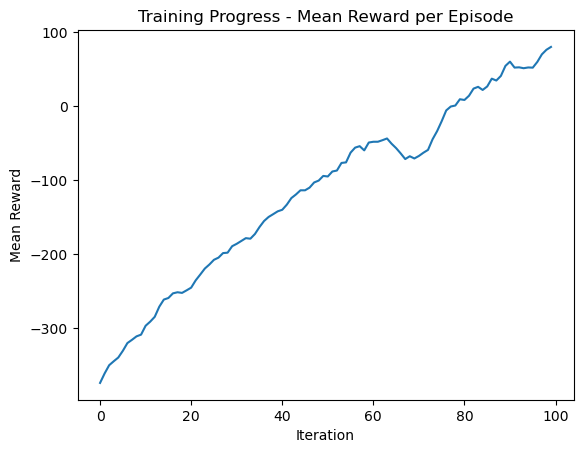

In [8]:
plt.plot(results)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('MOG and Energy Distance - HalfCheetah-v4')
plt.show()

In [10]:
import csv
with open('training_rewards.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Iteration', 'Mean Reward'])  # Writing header of the CSV
    for iteration, reward in enumerate(results):
        writer.writerow([iteration, reward])  # Writing data